In [2]:
%matplotlib inline
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cdb_extras.xarray_support as cdbxr  # a convenient Python library for accessing the COMPASS database
from scipy.signal import savgol_filter, detrend, correlate
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import AutoReg, AR

from statsmodels.tsa.stattools import grangercausalitytests

In [35]:
# Constants
N_SHOT = 17229
T_START = 1071
T_END = 1195

CHANNEL_APD = 13

# OBS. this requires the the following .mat files to exist at these locations!
DATA_DIR = './sumtraic2022/gSPRT_data/'
APD_ELM = DATA_DIR + '17229_Li_ELMs.mat'
MIRNOV_ELM = DATA_DIR + '17229_Mirnov_ELMs.mat'

In [1]:
# Load the relevant signals
shot = cdbxr.Shot(N_SHOT)

_APD = shot['APD.light_profile'].sel(time=slice(T_START, T_END)).isel(R=CHANNEL_APD)
s_APD = _APD.data / np.abs(_APD.data).max()
t_APD = _APD.time

# sample freq. is 1:20 between APD and Mirnov, skip time averaging...
_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(T_START, T_END))[1::20]
s_Mirnov = _Mirnov.data / np.abs(_Mirnov.data).max()
t_Mirnov = _Mirnov.time

# include Halpha signals, at the time, only for indicating the ELMs temporal locations
_Halpha = shot['Halpha'].sel(time=slice(T_START, T_END))[1::20]
s_Halpha = -_Halpha.data / np.abs(_Halpha.data).max()
t_Halpha = _Halpha.time

# load ELM times
time_APD_ELMs = scipy.io.loadmat(APD_ELM)['A']
time_Mirnov_ELMs = scipy.io.loadmat(MIRNOV_ELM)['A']

NameError: name 'cdbxr' is not defined

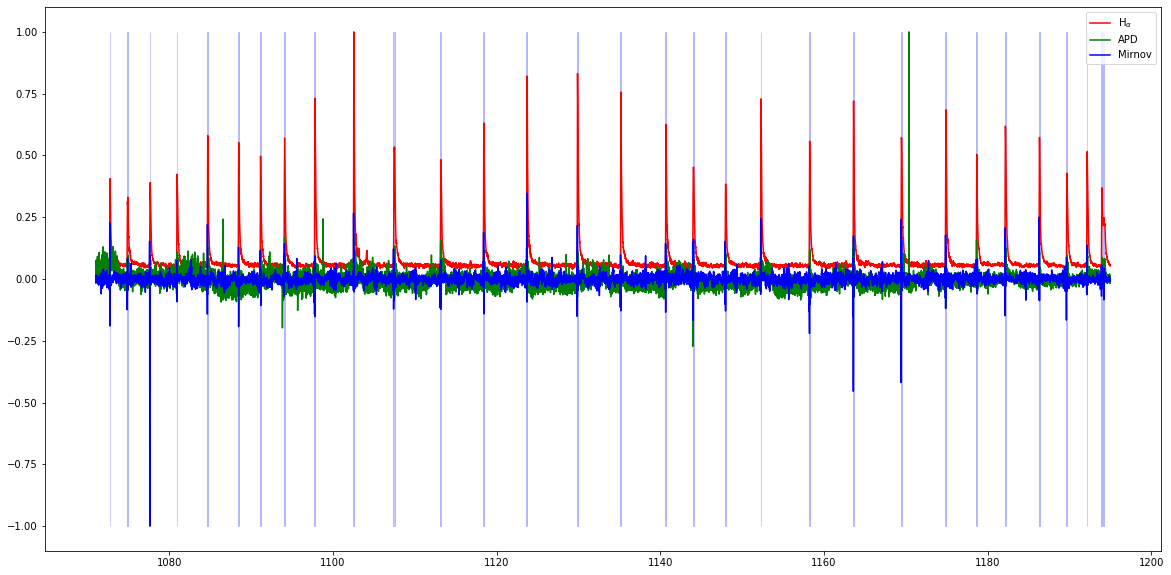

In [37]:
# plot signals with ELM intervals
plt.figure(figsize=(20, 10))
plt.plot(t_Halpha, s_Halpha, 'r', label=r'H$_\alpha$')
plt.plot(t_APD, s_APD, 'g', label='APD')
plt.plot(t_Mirnov, s_Mirnov, 'b', label='Mirnov')

for elm in time_Mirnov_ELMs:
    plt.fill_between(elm, -np.ones(elm.shape), np.ones(elm.shape), color='b', alpha=.2)

plt.legend()
plt.show()

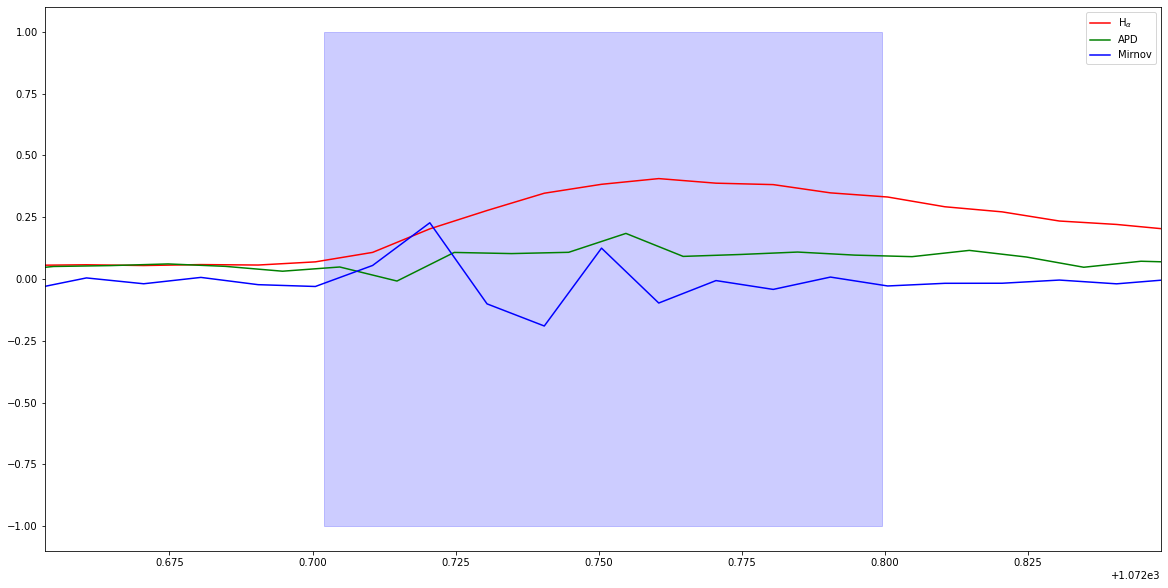

In [28]:
# zoom in on an ELM
plt.figure(figsize=(20, 10))
plt.plot(t_Halpha, s_Halpha, 'r', label=r'H$_\alpha$')
plt.plot(t_APD, s_APD, 'g', label='APD')
plt.plot(t_Mirnov, s_Mirnov, 'b', label='Mirnov')

i_elm = 0
elm = time_Mirnov_ELMs[i_elm]
plt.fill_between(elm, -np.ones(elm.shape), np.ones(elm.shape), color='b', alpha=.2)

# the Mirnov intervals are much reliable than that of the APD
#elm = time_APD_ELMs[i_elm]
#plt.fill_between(elm, -np.ones(elm.shape), np.ones(elm.shape), color='r', alpha=.2)

margin = np.diff(elm)/2
plt.xlim(elm[0]-margin, elm[1]+margin)

plt.legend()
plt.show()

In [29]:
# take 1st difference of the 3 signals --> stationary signals
#s_APD -= savgol_filter(s_APD, 11, 9)
s_APD = np.diff(s_APD)[1:]
t_APD = t_APD[1:-1]

s_Mirnov = np.diff(s_Mirnov)[1:]
t_Mirnov = t_Mirnov[1:-1]

#s_Halpha = np.diff(s_Halpha)[1:]
#t_Halpha = t_Halpha[1:-1]

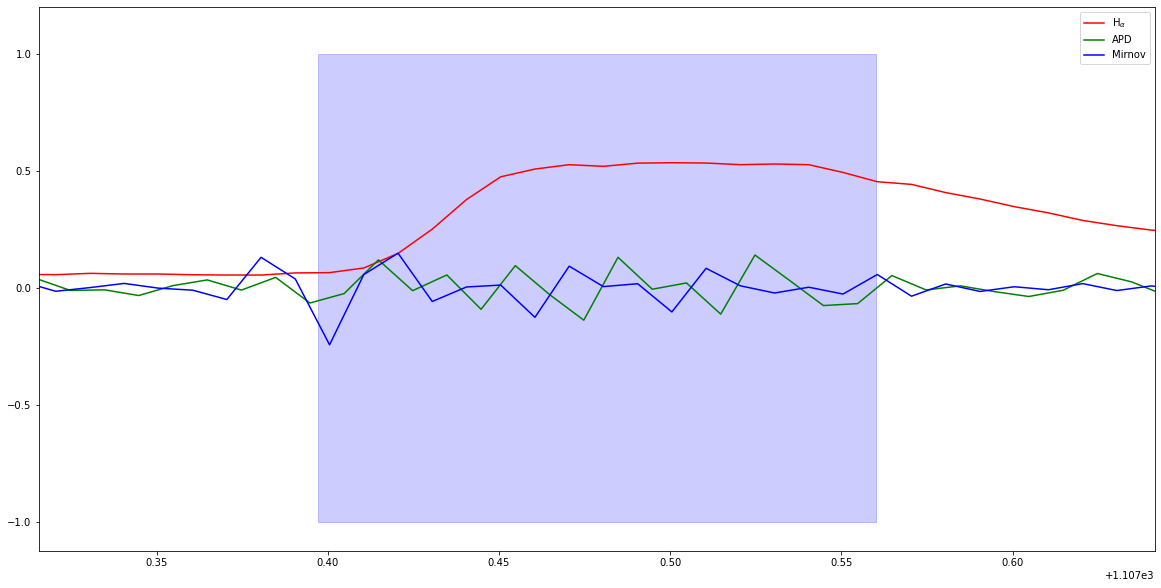

In [30]:
# zoom in on an ELM
plt.figure(figsize=(20, 10))
plt.plot(t_Halpha, s_Halpha, 'r', label=r'H$_\alpha$')
plt.plot(t_APD, s_APD, 'g', label='APD')
plt.plot(t_Mirnov, s_Mirnov, 'b', label='Mirnov')

i_elm = 10
elm = time_Mirnov_ELMs[i_elm]
plt.fill_between(elm, -np.ones(elm.shape), np.ones(elm.shape), color='b', alpha=.2)

# the Mirnov intervals are much reliable than that of the APD
#elm = time_APD_ELMs[i_elm]
#plt.fill_between(elm, -np.ones(elm.shape), np.ones(elm.shape), color='r', alpha=.2)

margin = np.diff(elm)/2
plt.xlim(elm[0]-margin, elm[1]+margin)

plt.legend()
plt.show()

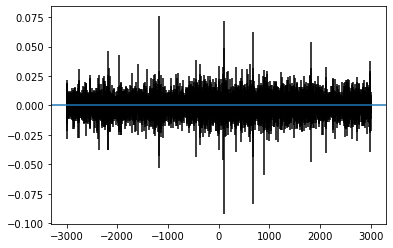

In [21]:
i_elm = 10
elm = time_Mirnov_ELMs[i_elm]

plt.xcorr(s_APD, s_Mirnov, maxlags=3000)
plt.show()

23
14
5


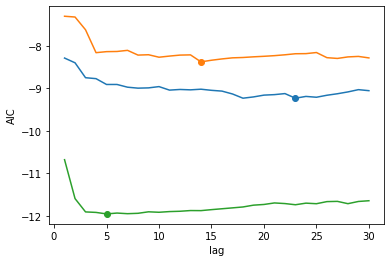

In [31]:
# finding the optimal lag p for AR(p), here we do it between two ELMs (is this reasonable to do?)
max_lag = 30
aic = np.zeros(max_lag)

start = 1120
end = 1121

for s, t in zip([s_Mirnov, s_APD, s_Halpha], [t_Mirnov, t_APD, t_Halpha]):
    ss = s[(start<t)&(t<end)]
    for i in range(max_lag):

        # auto regression
        model = AutoReg(ss, i+1)
        aic[i] = model.fit().aic
    
    plt.plot(np.linspace(1, max_lag, max_lag), aic)
    plt.scatter(aic.argmin()+1, aic.min())
    print(aic.argmin()+1)
    
        
plt.ylabel('AIC')
plt.xlabel('lag')
plt.show()

14


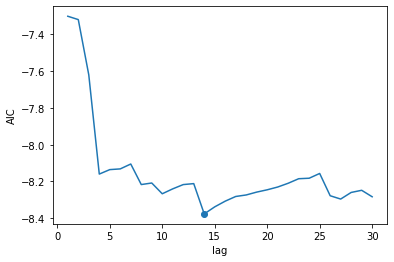

In [33]:
ss = s_APD[(start<t_APD)&(t_APD<end)]
for i in range(max_lag):

    # auto regression
    model = AutoReg(ss, i+1)
    aic[i] = model.fit().aic

plt.plot(np.linspace(1, max_lag, max_lag), aic)
plt.scatter(aic.argmin()+1, aic.min())
print(aic.argmin()+1)
    
        
plt.ylabel('AIC')
plt.xlabel('lag')
plt.show()

In [192]:
### timestep = 3*np.diff(time_Mirnov_ELMs).min()

start = float(t_APD[0].time)
end = float(t_APD[-1].time)

n = int((end - start) / timestep)

#intervals = [[start+i*timestep, start+(i+1)*timestep] for i in range(n)]

p, tp = [], []

n = 30
lag = 7

it = np.arange(0, len(t_APD), n)

for i in it:
    x = s_Mirnov[i:i+n]
    y = s_APD[i:i+n]
    t = t_APD[i:i+n].mean()
    
    df = pd.DataFrame(data=zip(x, y))
    try:
        res = grangercausalitytests(df, [lag], verbose=False)
        p.append(1-float(res[lag][0]['ssr_ftest'][1]))
        tp.append(t)
    except ValueError:
        print('shiet')
        continue       

shiet


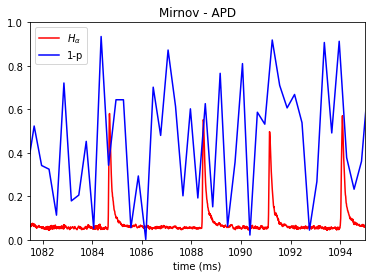

In [193]:
fig=plt.figure()

#plt.plot(t_Mirnov, s_Mirnov/s_Mirnov.max(), 'b', alpha=.2, label='Mirnov')
#plt.plot(t_APD, s_APD/s_APD.max(), 'r', alpha=.2)

plt.plot(t_Halpha, s_Halpha/s_Halpha.max(), 'r', label=r'$H_\alpha$')

plt.plot(tp, p, 'b', label='1-p')

#plt.plot(t_Mirnov, s_Mirnov)
#plt.plot(t_APD, s_APD, 'g')

plt.xlim(1081.5, 1095)
plt.ylim(0, 1)

plt.xlabel('time (ms)')
plt.legend()
plt.title('Mirnov - APD')

fig.savefig('Mirnov_APD.png', format='png')


NameError: name 'r' is not defined

In [100]:
# these two time series are not defined on the same time points. We obtain this by averaging!
def time_series_average(time_arr, signal_arr, timestep=None, start=None, end=None):

    assert len(time_arr) == len(signal_arr)
    
    dt_min = max(np.diff(t_APD).max(), np.diff(t_Mirnov).max())
    if timestep is None:
        timestep = dt_min
    elif timestep < dt_min:
        timestep = dt_min
        print(f'too small timestep. Using timestep = {dt_min}')
    
    if start is None:
        start = t_APD[0]
    if end is None:
        end = t_APD[-1]

    assert len(time_arr) > (end - start) / timestep, 'too short time_step!'
   
    time = np.arange(start, end-timestep, timestep)
    
    # optimize this?
    signal_ave = np.array([signal_arr[(t<=time_arr)&(time_arr<t+timestep)].mean() for t in time])
    time += timestep / 2
    
    return time, signal_ave

In [101]:
# OBS for larger intervals, this may take up to a minute to run
at_APD, as_APD = time_series_average(t_APD, s_APD, start=T_START, end=T_END)
at_Mirnov, as_Mirnov = time_series_average(t_Mirnov, s_Mirnov, start=T_START, end=T_END)

AssertionError: too short time_step!

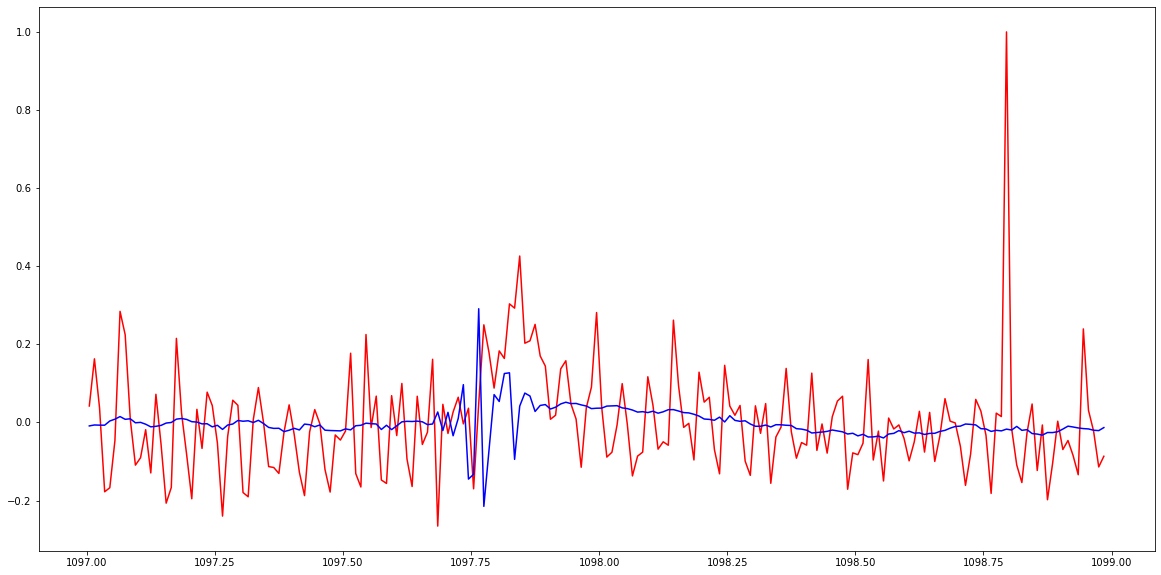

In [134]:
plt.figure(figsize=(20, 10))
plt.plot(at_APD, as_APD, 'r')
plt.plot(at_Mirnov, as_Mirnov, 'b')
plt.show()

# make stationary

In [1]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(s_APD)
kpss_test(s_Mirnov)

NameError: name 's_APD' is not defined

In [127]:
ts_df = pd.DataFrame(columns=['Mirnov', 'APD'], data=zip(as_Mirnov, as_APD))
gc = grangercausalitytests(ts_df, 30)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1840  , p=0.6684  , df_denom=195, df_num=1
ssr based chi2 test:   chi2=0.1869  , p=0.6655  , df=1
likelihood ratio test: chi2=0.1868  , p=0.6656  , df=1
parameter F test:         F=0.1840  , p=0.6684  , df_denom=195, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8160  , p=0.4437  , df_denom=192, df_num=2
ssr based chi2 test:   chi2=1.6745  , p=0.4329  , df=2
likelihood ratio test: chi2=1.6674  , p=0.4344  , df=2
parameter F test:         F=0.8160  , p=0.4437  , df_denom=192, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4092  , p=0.7466  , df_denom=189, df_num=3
ssr based chi2 test:   chi2=1.2729  , p=0.7356  , df=3
likelihood ratio test: chi2=1.2688  , p=0.7366  , df=3
parameter F test:         F=0.4092  , p=0.7466  , df_denom=189, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1278  , p=0.3448  

In [128]:
ts_df = pd.DataFrame(columns=['APD', 'Mirnov'], data=zip(as_APD, as_Mirnov))
gc = grangercausalitytests(ts_df, 30)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6479  , p=0.4219  , df_denom=195, df_num=1
ssr based chi2 test:   chi2=0.6578  , p=0.4173  , df=1
likelihood ratio test: chi2=0.6568  , p=0.4177  , df=1
parameter F test:         F=0.6479  , p=0.4219  , df_denom=195, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1689  , p=0.3129  , df_denom=192, df_num=2
ssr based chi2 test:   chi2=2.3987  , p=0.3014  , df=2
likelihood ratio test: chi2=2.3842  , p=0.3036  , df=2
parameter F test:         F=1.1689  , p=0.3129  , df_denom=192, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4468  , p=0.7199  , df_denom=189, df_num=3
ssr based chi2 test:   chi2=1.3900  , p=0.7079  , df=3
likelihood ratio test: chi2=1.3851  , p=0.7090  , df=3
parameter F test:         F=0.4468  , p=0.7199  , df_denom=189, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9620  , p=0.4296  

# find optimal lag for AR

Minimum AIC :  -7.497203910686503 Lag order =  30


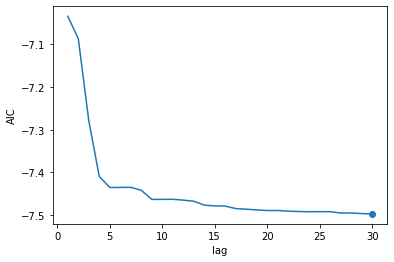

In [23]:
max_lag = 30
aic = np.zeros(max_lag)

for i in range(max_lag):
    
    # auto regression
    model = AutoReg(s_APD, i+1)
    aic[i] = model.fit().aic
    
plt.plot(np.linspace(1, max_lag, max_lag), aic)
plt.scatter(aic.argmin()+1, aic.min())
plt.ylabel('AIC')
plt.xlabel('lag')

print('Minimum AIC : ', aic.min(), 'Lag order = ', aic.argmin()+1)

In [102]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import AR, AutoReg
from scipy.stats import f


def compute_granger(x, y, d=2):
    """Computes F value weather y granger causes x
    
    :param numpy.ndarray x: target array shape (1D)
    :param numpy.ndarray y: source array (1D)
    :param int d: maxlag of autoregression
 
    :return: log(F) value for y -> x
    :rtype: float

    """

    T = len(x)

    ar = AutoReg(x, lags=d)
    ar_fit = ar.fit()
    var = VAR(np.array([x, y]).T)
    var_fit = var.fit(maxlags=d)

    # The formula's origin is at Bressler, Granger causality: a well established methodology, NeuroImage (2010),
    F_bressler = (((ar_fit.resid ** 2).sum() - (var_fit.resid[:, 0] ** 2).sum()) / d) \
                 / ((var_fit.resid[:, 0] ** 2).sum() / (T - 2 * d - 1))

    p_val = compute_pvals(F_bressler, d, T - 2 * d - 1)

    return np.log(ar_fit.resid.var() / var_fit.resid.var(axis=0)[0]), p_val, F_bressler

def compute_pvals(F, m1, m2):
    return 1 - f.cdf(F, m1, m2)

def compute_granger_bf(x, y, d=2):
    """Computes back and forth F value for granger causality
        .. math:: F = \log( \sigma_{2}^{2} / \sigma_{1}^{2} )
    :param numpy.ndarray x: 1st time series,  array 1D shape
    :param numpy.ndarray y: 2nd time series,  array 1D shape
    :param int d: maxlag for autoregression
    
    :return: log variance ratios, pvalues, F values : each in x -> y, y -> x order
    :rtype: tuple of float

    """
    h_y2x, p_y2x, Fbress1 = compute_granger(x, y, d)
    h_x2y, p_x2y, Fbress2 = compute_granger(y, x, d)

    return h_x2y, h_y2x, p_x2y, p_y2x, Fbress1, Fbress2

In [81]:
# Code from previous year, sent to us by Miklós
import warnings
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import AR

def get_gcc(x, y, d=9):
    """Computes F value wether y Granger causes x

    :param numpy.ndarray x: target array shape (1D)
    :param numpy.ndarray y: source array (1D)
    :param int d: maxlag of autoregression
    :return: log(F) value for y -> x
    :rtype: float

    """
    warnings.simplefilter("ignore")
    
    # for definition of AR => (https://en.wikipedia.org/wiki/Autoregressive_model#Definition)
    ar = AR(x)
    ar_fit = ar.fit(d)
    var = VAR(np.array([x, y]).T)
    var_fit = var.fit(d)
   
    #print(var_fit.summary())
    
    return np.log(ar_fit.resid.var() / var_fit.resid.var(axis=0)[0])

In [96]:
LAG = 25

x = as_APD
y = as_Mirnov


assert np.array_equal(at_APD, at_Mirnov)
    
t_gcc = np.zeros(at_APD.size - LAG)
sxy_gcc = np.zeros(t_gcc.shape)
syx_gcc = np.zeros(t_gcc.shape)

for i, _ in enumerate(t_gcc):
    
    t_gcc[i] = at_APD[i+LAG]

    sxy_gcc[i] = get_gcc(x[:i+LAG], y[:i+LAG])
    syx_gcc[i] = get_gcc(y[:i+LAG], x[:i+LAG])

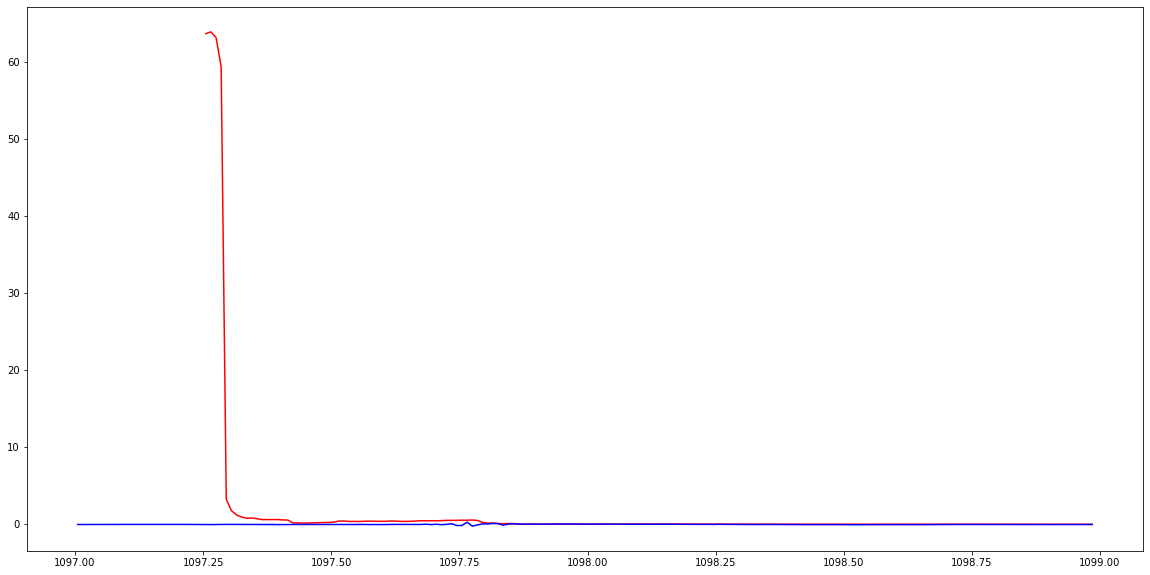

In [97]:
plt.figure(figsize=(20, 10))
plt.plot(t_gcc, sxy_gcc, 'r')
plt.plot(at_Mirnov, as_Mirnov, 'b')
plt.show()

In [112]:
WINDOW = 21

t_gcc = np.zeros(t_APD.size - WINDOW + 1)
sxy_gcc = np.zeros(t_gcc.shape)
syx_gcc = np.zeros(t_gcc.shape)

for i, _ in enumerate(t_gcc):
    t_gcc[i] = t_APD[i+int((WINDOW-1)/2)]

    x = s_APD[i:i+WINDOW]
    y = s_Mirnov[i:i+WINDOW]

    sxy_gcc[i] = get_gcc(x, y, 25)
    syx_gcc[i] = get_gcc(y, x, 25)

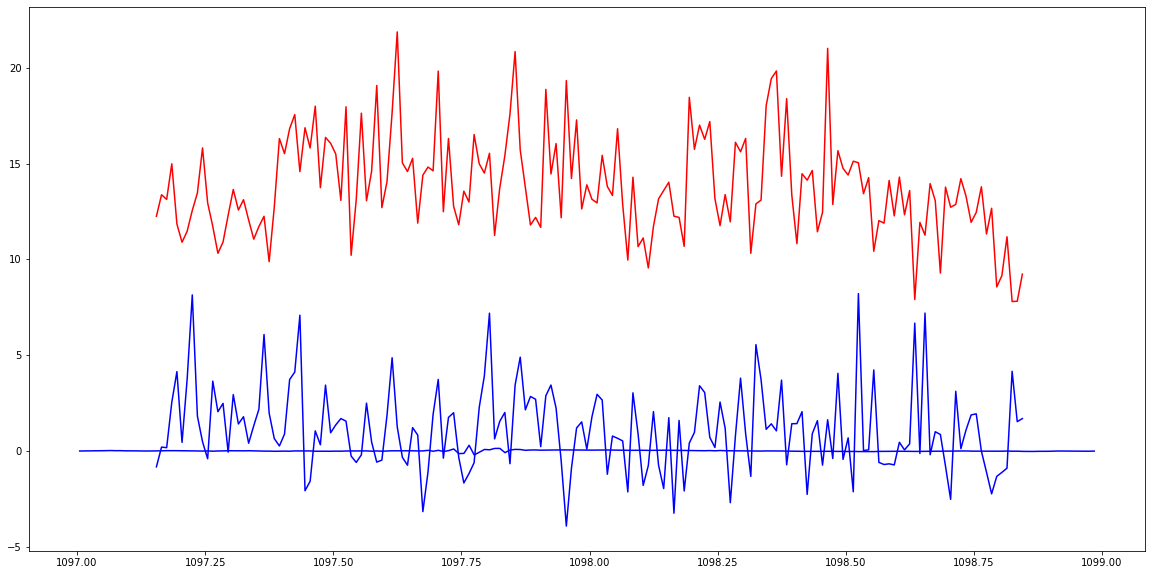

In [111]:
plt.figure(figsize=(20, 10))
plt.plot(t_gcc, sxy_gcc, 'r')

plt.plot(t_gcc, syx_gcc, 'b')
plt.plot(at_Mirnov, as_Mirnov, 'b')
plt.show()

# test example for Granger causality test

In [11]:
#build the time series, just a simple AR(1)
t1 = [0.1*np.random.normal()]
for _ in range(100):
    t1.append(0.5*t1[-1] + 0.1*np.random.normal())

In [12]:
#build the time series that is granger caused by t1
t2 = [0.1*np.random.normal() for item in t1]

In [13]:
#adjust t1 and t2
t1 = t1[5:]
t2 = t2[:-5]

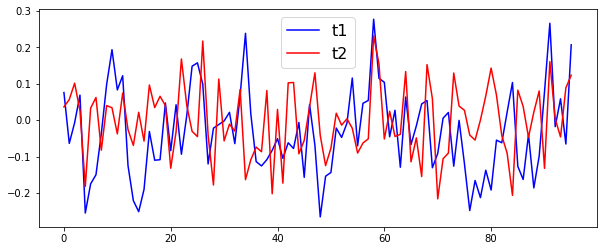

In [14]:
plt.figure(figsize=(10,4))
plt.plot(t1, color='b')
plt.plot(t2, color='r')

plt.legend(['t1', 't2'], fontsize=16)

In [15]:
ts_df = pd.DataFrame(columns=['t2', 't1'], data=zip(t2,t1))
gc_res = grangercausalitytests(ts_df, 10)
gc_res


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6371  , p=0.4268  , df_denom=92, df_num=1
ssr based chi2 test:   chi2=0.6579  , p=0.4173  , df=1
likelihood ratio test: chi2=0.6556  , p=0.4181  , df=1
parameter F test:         F=0.6371  , p=0.4268  , df_denom=92, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2572  , p=0.7738  , df_denom=89, df_num=2
ssr based chi2 test:   chi2=0.5432  , p=0.7622  , df=2
likelihood ratio test: chi2=0.5416  , p=0.7628  , df=2
parameter F test:         F=0.2572  , p=0.7738  , df_denom=89, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5041  , p=0.6804  , df_denom=86, df_num=3
ssr based chi2 test:   chi2=1.6355  , p=0.6514  , df=3
likelihood ratio test: chi2=1.6213  , p=0.6546  , df=3
parameter F test:         F=0.5041  , p=0.6804  , df_denom=86, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4256  , p=0.7897  , df_d

{1: ({'ssr_ftest': (0.6370819008281466, 0.4268249896023423, 92.0, 1),
   'ssr_chi2test': (0.6578563106377601, 0.41731776784865116, 1),
   'lrtest': (0.6555890089330774, 0.4181215218014793, 1),
   'params_ftest': (0.6370819008281382, 0.42682498960234594, 92.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.25715651291068614, 0.7738197332294707, 89.0, 2),
   'ssr_chi2test': (0.5432070160360561, 0.7621563900876954, 2),
   'lrtest': (0.5416434948391498, 0.7627524468798259, 2),
   'params_ftest': (0.2571565129106876, 0.773819733229467, 89.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.5041441185896023, 0.6804368670776684, 86.0, 3),
   'ssr_chi2test': (1.635537314959291, 0.6513590836572405, 3),
   'lrtest': (1.621322110719575, 0.6545648960702832, 3),
   'params_ftest': (0.5041441185896031, 0.6804368670776684, 86.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0.

# test with ELM data

In [223]:
# Constants
N_SHOT = 17229
T_START = 1096.4
T_END = 1097.6

CHANNEL_APD = 13

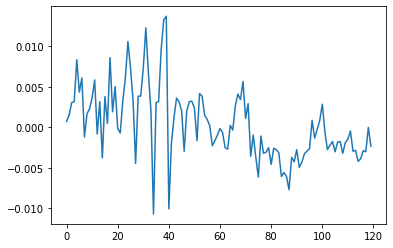

In [224]:
plt.plot(shot['Mirnov_A_rad_02_RAW'].sel(time=slice(T_START, T_END)).data[10::20])

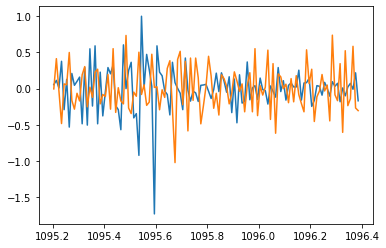

In [225]:
t = shot['APD.light_profile'].sel(time=slice(T_START, T_END)).isel(R=CHANNEL_APD).time

x = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(T_START, T_END)).data[10::20]
y = shot['APD.light_profile'].sel(time=slice(T_START, T_END)).isel(R=CHANNEL_APD).data

x /= np.abs(x).max()
y /= np.abs(y).max()

data = pd.DataFrame(columns=['Mirnov', 'APD'], data=zip(y, x))

# take 1 first difference
data['APD'] = data['APD'] - data['APD'].shift(1)
data['Mirnov'] = data['Mirnov'] - data['Mirnov'].shift(1)
t = t[:-1]
data = data.dropna()

plt.plot(t, data['APD'])

plt.plot(t, data['Mirnov'])


In [222]:
gc_res1 = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9472  , p=0.0890  , df_denom=105, df_num=1
ssr based chi2 test:   chi2=3.0314  , p=0.0817  , df=1
likelihood ratio test: chi2=2.9897  , p=0.0838  , df=1
parameter F test:         F=2.9472  , p=0.0890  , df_denom=105, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3547  , p=0.2626  , df_denom=102, df_num=2
ssr based chi2 test:   chi2=2.8421  , p=0.2415  , df=2
likelihood ratio test: chi2=2.8051  , p=0.2460  , df=2
parameter F test:         F=1.3547  , p=0.2626  , df_denom=102, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4785  , p=0.2250  , df_denom=99, df_num=3
ssr based chi2 test:   chi2=4.7492  , p=0.1911  , df=3
likelihood ratio test: chi2=4.6459  , p=0.1996  , df=3
parameter F test:         F=1.4785  , p=0.2250  , df_denom=99, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7051  , p=0.1552  , 

In [227]:
gc_res2 = grangercausalitytests(data, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0310  , p=0.8606  , df_denom=115, df_num=1
ssr based chi2 test:   chi2=0.0318  , p=0.8585  , df=1
likelihood ratio test: chi2=0.0318  , p=0.8585  , df=1
parameter F test:         F=0.0310  , p=0.8606  , df_denom=115, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2089  , p=0.8118  , df_denom=112, df_num=2
ssr based chi2 test:   chi2=0.4365  , p=0.8039  , df=2
likelihood ratio test: chi2=0.4356  , p=0.8043  , df=2
parameter F test:         F=0.2089  , p=0.8118  , df_denom=112, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4831  , p=0.6947  , df_denom=109, df_num=3
ssr based chi2 test:   chi2=1.5425  , p=0.6725  , df=3
likelihood ratio test: chi2=1.5323  , p=0.6748  , df=3
parameter F test:         F=0.4831  , p=0.6947  , df_denom=109, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0828  , p=0.9875  

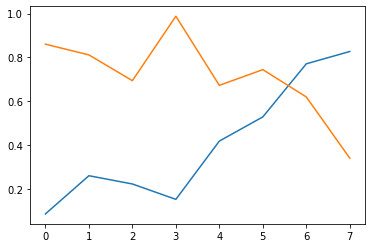

In [229]:
p1, p2 = [], []

for lag in gc_res:
    p1.append(gc_res1[lag][0]['ssr_ftest'][1])
    p2.append(gc_res2[lag][0]['ssr_ftest'][1])
    
plt.plot(p1)
plt.plot(p2)

In [95]:
# these two time series are not defined on the same time points. We obtain this by averaging!
def time_series_average(time_arr, signal_arr, timestep=None, start=None, end=None):

    assert len(time_arr) == len(signal_arr)
    
    dt_min = max(np.diff(t_APD).max(), np.diff(t_Mirnov).max())
    if timestep is None:
        timestep = dt_min
    elif timestep < dt_min:
        timestep = dt_min
        print(f'too small timestep. Using timestep = {dt_min}')
    
    if start is None:
        start = t_APD[0]
    if end is None:
        end = t_APD[-1]

    print(timestep*len(time_arr), end-start)
    assert len(time_arr) > (end - start) / timestep, 'too short time_step!'
   
    time = np.arange(start, end-timestep, timestep)
    
    # optimize this?
    signal_ave = np.array([signal_arr[(t<=time_arr)&(time_arr<t+timestep)].mean() for t in time])
    time += timestep / 2
    
    return time, signal_ave

In [96]:
# OBS for larger intervals, this may take up to a minute to run
at_APD, as_APD = time_series_average(t_APD, s_APD, start=T_START, end=T_END)
at_Mirnov, as_Mirnov = time_series_average(t_Mirnov, s_Mirnov, start=T_START, end=T_END)

1.9800000940449536 2


AssertionError: too short time_step!

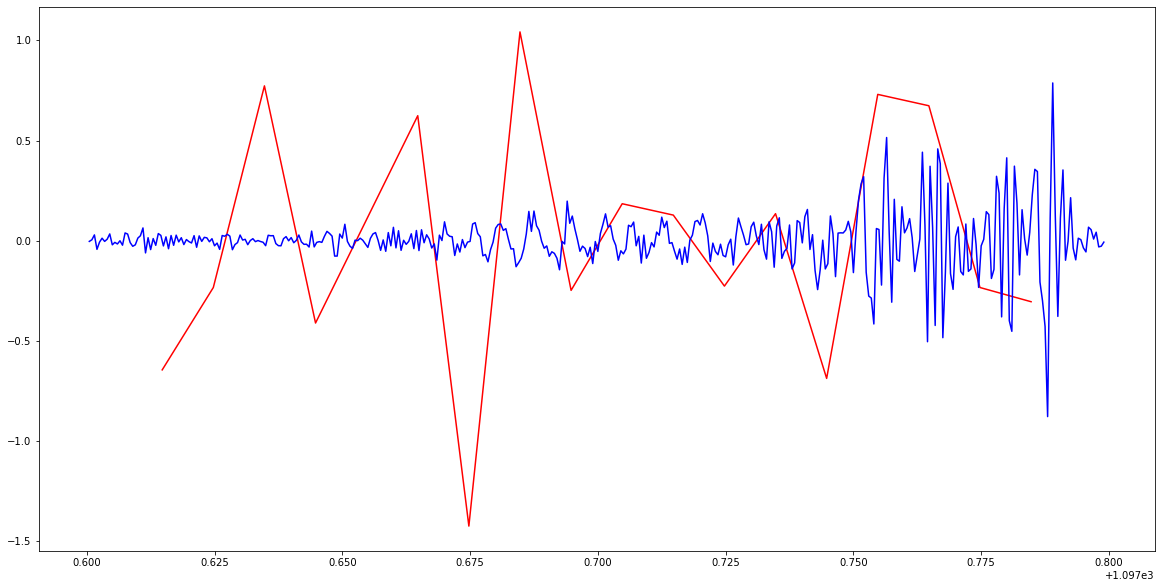

In [56]:
plt.figure(figsize=(20, 10))
plt.plot(t_APD, s_APD, 'r')
plt.plot(t_Mirnov, s_Mirnov, 'b')
plt.show()